In [3]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost shap kagglehub

<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\d'
/var/folders/5r/_fpjyd7j4w31rq11_t7wcprm0000gn/T/ipykernel_2933/292979864.py:46: SyntaxWarning: invalid escape sequence '\d'
  df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype('float') if 'emp_length' in df.columns and df['emp_length'].dtype == 'object' else df['emp_length']
/var/folders/5r/_fpjyd7j4w31rq11_t7wcprm0000gn/T/ipykernel_2933/292979864.py:47: SyntaxWarning: invalid escape sequence '\d'
  df['term'] = df['term'].str.extract('(\d+)').astype('float') if 'term' in df.columns and df['term'].dtype == 'object' else df['term']


Best Params: {'adasyn__sampling_strategy': 0.3, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 7.309961566427755, 'classifier__subsample': 0.8}
Improved v2 XGBoost Report:
               precision    recall  f1-score   support

           0       0.92      0.78      0.84     17593
           1       0.24      0.50      0.32      2407

    accuracy                           0.75     20000
   macro avg       0.58      0.64      0.58     20000
weighted avg       0.84      0.75      0.78     20000

AUC: 0.7041975706478227
AUPRC: 0.24602839506002203
CV AUC Mean: 0.7221841460143651
Best Threshold: 0.6179349
Max F1 at thres: 0.3220883534136546


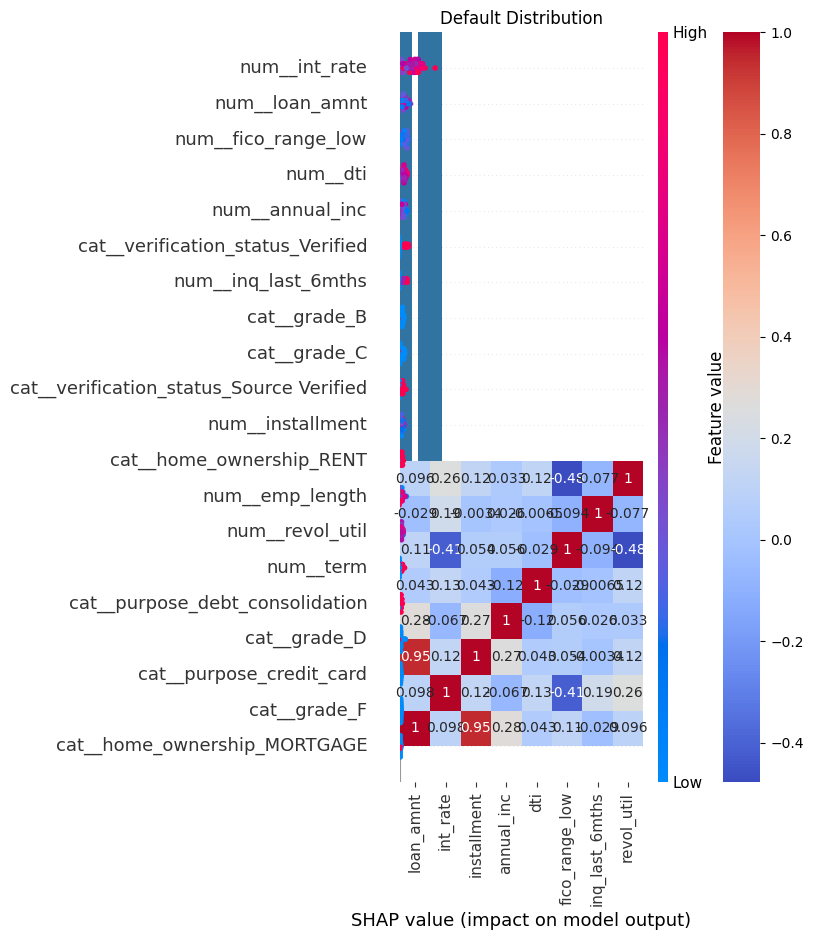

['credit_model_v2.pkl']

<Figure size 640x480 with 0 Axes>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import joblib

# 1. Загрузка
df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)
df = df.sample(100000, random_state=42)

df['target'] = df['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Default'] else 0)

# 2. Extended features
features = ['loan_amnt', 'int_rate', 'installment', 'grade', 'emp_length', 'annual_inc', 'dti', 'fico_range_low', 'term', 'home_ownership', 'verification_status', 'purpose', 'inq_last_6mths', 'revol_util']
df = df[features + ['target']]

# 3. EDA
sns.countplot(x='target', data=df)
plt.title('Default Distribution')
plt.savefig('default_dist.png')

# Fix for tolist error: add .columns
num_cols_defined = df.select_dtypes(include=np.number).columns.drop('target', errors='ignore').tolist()
cat_cols_defined = df.select_dtypes(include='object').columns.tolist()  # Fixed: .columns.tolist()

corr = df[num_cols_defined].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.savefig('corr_credit.png')

# 4. Feature Eng with fix
if 'revol_util' in df.columns:
    if df['revol_util'].dtype == 'object':
        df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float') / 100.0

df['income_log'] = np.log(df['annual_inc'] + 1) if 'annual_inc' in df.columns else np.nan
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype('float') if 'emp_length' in df.columns and df['emp_length'].dtype == 'object' else df['emp_length']
df['term'] = df['term'].str.extract('(\d+)').astype('float') if 'term' in df.columns and df['term'].dtype == 'object' else df['term']

# Define cols BEFORE imputer
cat_cols = [col for col in ['grade', 'home_ownership', 'verification_status', 'purpose'] if col in df.columns]
num_cols = [col for col in features if col not in cat_cols]

# Impute
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')
df[num_cols] = imputer_num.fit_transform(df[num_cols])
if cat_cols:
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ])

# 5. Split
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. ImbPipeline with ADASYN
pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='auc'))
])

# 7. Extended tuning
scale_pos = (len(y_train) - sum(y_train)) / sum(y_train)
params = {
    'adasyn__sampling_strategy': ['minority', 0.3, 0.5],
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__scale_pos_weight': [scale_pos / 2, scale_pos, scale_pos * 2],
    'classifier__subsample': [0.8, 1.0]
}

grid = GridSearchCV(pipe, params, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

# 8. Evaluation with threshold tuning
best_model = grid.best_estimator_
y_prob = best_model.predict_proba(X_test)[:,1]
prec, rec, thres = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * rec * prec / (rec + prec)
best_thres = thres[np.argmax(f1_scores[:-1])]
y_pred = (y_prob >= best_thres).astype(int)

print('Best Params:', grid.best_params_)
print('Improved v2 XGBoost Report:\n', classification_report(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_prob))
print('AUPRC:', average_precision_score(y_test, y_prob))
print('CV AUC Mean:', cross_val_score(best_model, X, y, cv=5, scoring='roc_auc').mean())
print('Best Threshold:', best_thres)
print('Max F1 at thres:', max(f1_scores[:-1]))

# 9. SHAP
X_test_trans = best_model.named_steps['preprocessor'].transform(X_test)
explainer = shap.Explainer(best_model.named_steps['classifier'], X_test_trans)
shap_values = explainer(X_test_trans[:100])
shap.summary_plot(shap_values, X_test_trans[:100], feature_names=best_model.named_steps['preprocessor'].get_feature_names_out())
plt.savefig('shap_summary.png')

# Save
joblib.dump(best_model, 'credit_model_v2.pkl')